In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/togo-dapaong_qc.csv')

# Initial inspection
print("🔍 DATA OVERVIEW")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

In [ ]:
# CELL 2: DATA PROFILING & MISSING VALUES ANALYSIS
print("📊 DATA PROFILING REPORT")
print("=" * 50)

# 1. Basic Info
print("1. DATASET BASIC INFORMATION:")
print(f"   - Shape: {df.shape} (rows, columns)")
print(f"   - Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. Data Types
print("\n2. DATA TYPES:")
print(df.dtypes)

# 3. Missing Values Analysis (REQUIRED BY ASSIGNMENT)
print("\n3. MISSING VALUES ANALYSIS:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_report = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})

print(missing_report)

# 4. Flag columns with >5% missing values (REQUIRED)
high_missing = missing_percent[missing_percent > 5]
print(f"\n4. COLUMNS WITH >5% MISSING VALUES ({len(high_missing)} found):")
if len(high_missing) > 0:
    for col, percent in high_missing.items():
        print(f"   - {col}: {percent:.2f}% missing")
else:
    print("   ✅ No columns with >5% missing values!")

📊 DATA PROFILING REPORT
1. DATASET BASIC INFORMATION:
   - Shape: (525600, 19) (rows, columns)
   - Memory usage: 104.76 MB

2. DATA TYPES:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object

3. MISSING VALUES ANALYSIS:
               Missing Count  Missing Percentage
Timestamp                  0                 0.0
GHI                        0                 0.0
DNI                        0                 0.0
DHI                        0                 0.0
ModA                       0                 0.0
ModB                       0                 0.0

In [ ]:
# CELL 3: OUTLIER DETECTION & BASIC CLEANING
print("🔍 OUTLIER DETECTION ANALYSIS")
print("=" * 50)

# 1. Select columns for outlier detection (AS REQUIRED)
outlier_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
available_columns = [col for col in outlier_columns if col in df.columns]

print(f"1. ANALYZING OUTLIERS IN: {available_columns}")

# 2. Calculate Z-scores for each column
z_scores = {}
outlier_counts = {}

for col in available_columns:
    # Remove NaN values for Z-score calculation
    clean_data = df[col].dropna()
    
    if len(clean_data) > 0:
        z_scores[col] = np.abs(stats.zscore(clean_data))
        outlier_counts[col] = (z_scores[col] > 3).sum()
    else:
        outlier_counts[col] = 0

# 3. Display outlier summary
print("\n2. OUTLIER SUMMARY (|Z-score| > 3):")
outlier_report = pd.DataFrame({
    'Column': list(outlier_counts.keys()),
    'Outlier Count': list(outlier_counts.values()),
    'Total Rows': [len(df[col].dropna()) for col in available_columns],
    'Outlier %': [f"{(outlier_counts[col]/len(df[col].dropna()))*100:.2f}%" 
                  for col in available_columns]
})

print(outlier_report)

# 4. Flag rows with multiple outliers (ADVANCED INSIGHT)
print("\n3. ROWS WITH MULTIPLE OUTLIERS:")
outlier_flags = pd.DataFrame()

for col in available_columns:
    if col in z_scores:
        outlier_flags[col] = z_scores[col] > 3

# Count outliers per row
outlier_flags['total_outliers'] = outlier_flags.sum(axis=1)
multi_outlier_rows = (outlier_flags['total_outliers'] > 1).sum()

print(f"   - Rows with >1 outlier: {multi_outlier_rows}")
print(f"   - This might indicate sensor malfunctions or extreme weather events")

🔍 OUTLIER DETECTION ANALYSIS
1. ANALYZING OUTLIERS IN: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

2. OUTLIER SUMMARY (|Z-score| > 3):
   Column  Outlier Count  Total Rows Outlier %
0     GHI            305      525600     0.06%
1     DNI           1062      525600     0.20%
2     DHI           3415      525600     0.65%
3    ModA            137      525600     0.03%
4    ModB            206      525600     0.04%
5      WS           3510      525600     0.67%
6  WSgust           3915      525600     0.74%

3. ROWS WITH MULTIPLE OUTLIERS:
   - Rows with >1 outlier: 3104
   - This might indicate sensor malfunctions or extreme weather events


In [ ]:
# CELL 4: DATA CLEANING & EXPORT
print("🧹 DATA CLEANING & PREPARATION")
print("=" * 50)

# Create a clean copy of the dataframe
df_clean = df.copy()

print("1. HANDLING MISSING VALUES:")
# Strategy: Median imputation for numeric columns (AS REQUIRED)
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    missing_before = df_clean[col].isna().sum()
    if missing_before > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        print(f"   - {col}: Filled {missing_before} missing values with median")

print("\n2. HANDLING OUTLIERS:")
# Option 1: Cap outliers (more conservative than removing)
for col in available_columns:
    if col in df_clean.columns and col in z_scores:
        # Find the outlier bounds
        clean_data = df[col].dropna()
        if len(clean_data) > 0:
            Q1 = clean_data.quantile(0.25)
            Q3 = clean_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers
            outliers_before = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
            df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
            outliers_after = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
            
            if outliers_before > 0:
                print(f"   - {col}: Capped {outliers_before} outliers using IQR method")

print("\n3. DATA QUALITY SUMMARY:")
print(f"   - Original shape: {df.shape}")
print(f"   - Cleaned shape: {df_clean.shape}")
print(f"   - Missing values removed: {(df.isna().sum().sum() - df_clean.isna().sum().sum())}")
print(f"   - Memory optimized: {df.memory_usage(deep=True).sum() / 1024**2:.2f}MB → {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f}MB")

# 4. EXPORT CLEANED DATA (REQUIRED)
print("\n4. EXPORTING CLEANED DATA:")
clean_file_path = '../data/benin_clean.csv'
df_clean.to_csv(clean_file_path, index=False)
print(f"   ✅ Cleaned data exported to: {clean_file_path}")
print(f"   - File contains {len(df_clean)} rows and {len(df_clean.columns)} columns")

# 5. VERIFICATION
print("\n5. DATA QUALITY VERIFICATION:")
print(f"   - Missing values in cleaned data: {df_clean.isna().sum().sum()}")
print(f"   - Data types preserved: {len(df_clean.columns) == len(df.columns)}")

🧹 DATA CLEANING & PREPARATION
1. HANDLING MISSING VALUES:
   - Comments: Filled 525600 missing values with median

2. HANDLING OUTLIERS:
   - GHI: Capped 1303 outliers using IQR method
   - DNI: Capped 50586 outliers using IQR method
   - DHI: Capped 7905 outliers using IQR method
   - ModA: Capped 1237 outliers using IQR method
   - ModB: Capped 1537 outliers using IQR method
   - WS: Capped 8708 outliers using IQR method
   - WSgust: Capped 7377 outliers using IQR method

3. DATA QUALITY SUMMARY:
   - Original shape: (525600, 19)
   - Cleaned shape: (525600, 19)
   - Missing values removed: 0
   - Memory optimized: 104.76MB → 104.76MB

4. EXPORTING CLEANED DATA:
   ✅ Cleaned data exported to: ../data/benin_clean.csv
   - File contains 525600 rows and 19 columns

5. DATA QUALITY VERIFICATION:
   - Missing values in cleaned data: 525600
   - Data types preserved: True


⏰ TIME SERIES ANALYSIS
1. PREPARING TIME SERIES DATA:
   - Time range: 2021-10-25 00:01:00 to 2022-10-25 00:00:00
   - Total duration: 364 days

2. SOLAR RADIATION TIME SERIES:


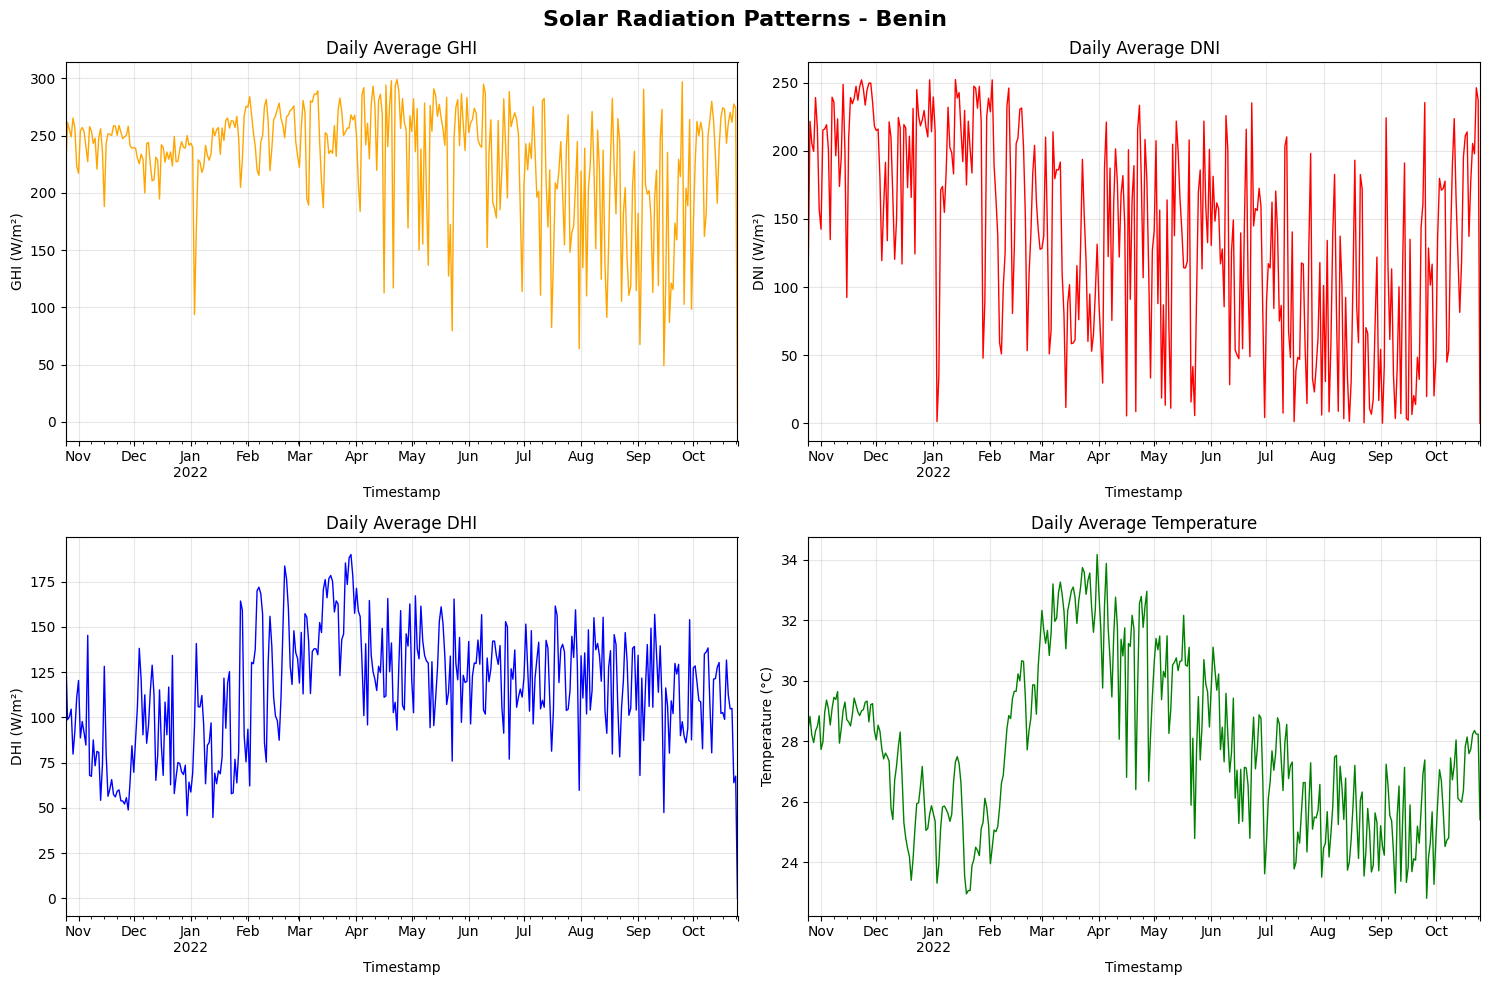


3. SEASONAL PATTERNS:


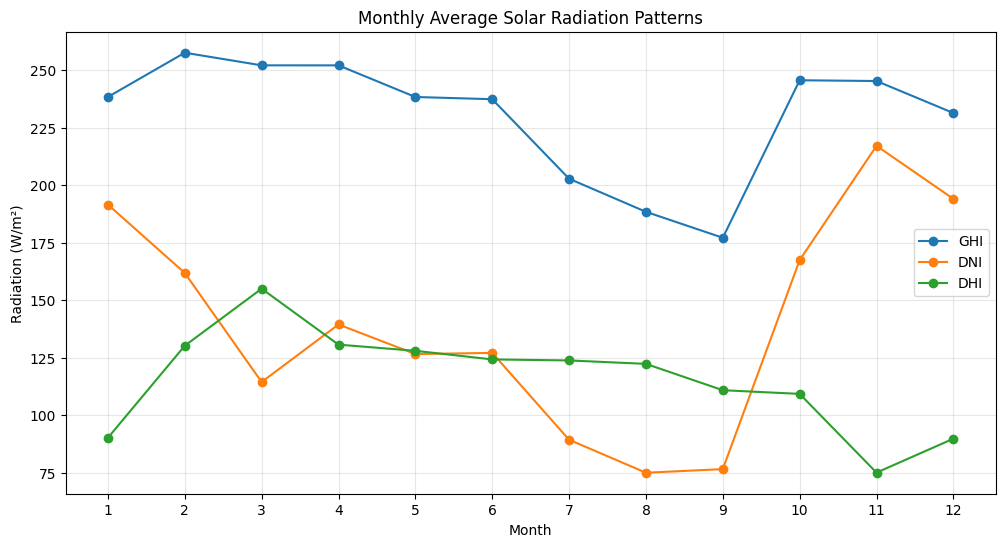


4. DAILY PATTERNS:


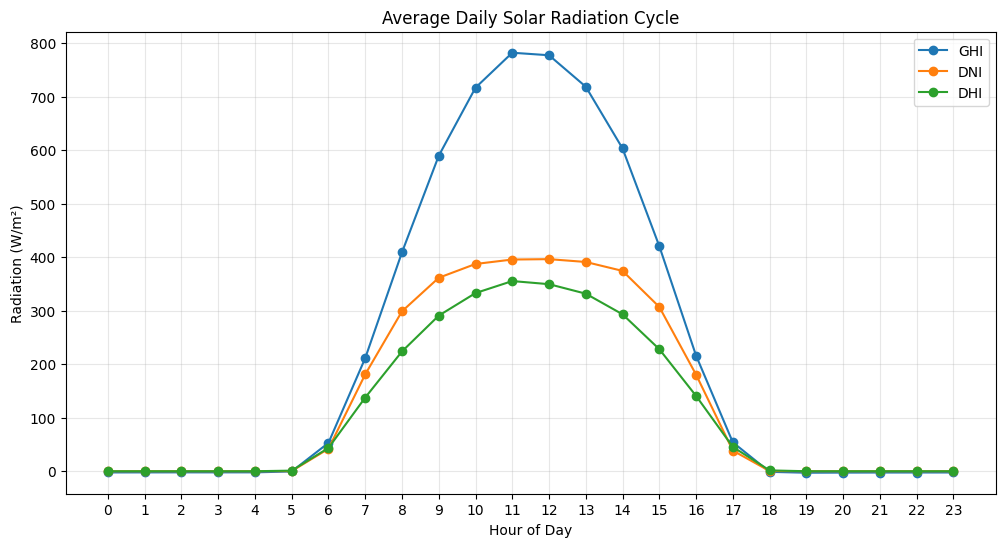

In [ ]:
# CELL 5: TIME SERIES ANALYSIS
print("⏰ TIME SERIES ANALYSIS")
print("=" * 50)

# 1. Convert Timestamp to datetime and set as index
print("1. PREPARING TIME SERIES DATA:")
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp', inplace=True)
print(f"   - Time range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"   - Total duration: {(df_clean.index.max() - df_clean.index.min()).days} days")

# 2. Solar Radiation Patterns Over Time
print("\n2. SOLAR RADIATION TIME SERIES:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Solar Radiation Patterns - Benin', fontsize=16, fontweight='bold')

# Plot GHI (Global Horizontal Irradiance)
if 'GHI' in df_clean.columns:
    df_clean['GHI'].resample('D').mean().plot(ax=axes[0,0], color='orange', linewidth=1)
    axes[0,0].set_title('Daily Average GHI')
    axes[0,0].set_ylabel('GHI (W/m²)')
    axes[0,0].grid(True, alpha=0.3)

# Plot DNI (Direct Normal Irradiance)
if 'DNI' in df_clean.columns:
    df_clean['DNI'].resample('D').mean().plot(ax=axes[0,1], color='red', linewidth=1)
    axes[0,1].set_title('Daily Average DNI')
    axes[0,1].set_ylabel('DNI (W/m²)')
    axes[0,1].grid(True, alpha=0.3)

# Plot DHI (Diffuse Horizontal Irradiance)
if 'DHI' in df_clean.columns:
    df_clean['DHI'].resample('D').mean().plot(ax=axes[1,0], color='blue', linewidth=1)
    axes[1,0].set_title('Daily Average DHI')
    axes[1,0].set_ylabel('DHI (W/m²)')
    axes[1,0].grid(True, alpha=0.3)

# Plot Temperature
if 'Tamb' in df_clean.columns:
    df_clean['Tamb'].resample('D').mean().plot(ax=axes[1,1], color='green', linewidth=1)
    axes[1,1].set_title('Daily Average Temperature')
    axes[1,1].set_ylabel('Temperature (°C)')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Monthly Patterns (Seasonal Analysis)
print("\n3. SEASONAL PATTERNS:")
df_clean['Month'] = df_clean.index.month

monthly_patterns = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
for column in ['GHI', 'DNI', 'DHI']:
    if column in monthly_patterns.columns:
        plt.plot(monthly_patterns.index, monthly_patterns[column], marker='o', label=column)

plt.title('Monthly Average Solar Radiation Patterns')
plt.xlabel('Month')
plt.ylabel('Radiation (W/m²)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))
plt.show()

# 4. Daily Patterns (Hourly Analysis)
print("\n4. DAILY PATTERNS:")
df_clean['Hour'] = df_clean.index.hour

# Only analyze if we have hourly data
if len(df_clean) > 24*7:  # At least a week of hourly data
    hourly_patterns = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI']].mean()
    
    plt.figure(figsize=(12, 6))
    for column in ['GHI', 'DNI', 'DHI']:
        if column in hourly_patterns.columns:
            plt.plot(hourly_patterns.index, hourly_patterns[column], marker='o', label=column)
    
    plt.title('Average Daily Solar Radiation Cycle')
    plt.xlabel('Hour of Day')
    plt.ylabel('Radiation (W/m²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    plt.show()
else:
    print("   - Insufficient data for hourly analysis")

📈 CORRELATION & RELATIONSHIP ANALYSIS
1. CORRELATION HEATMAP:


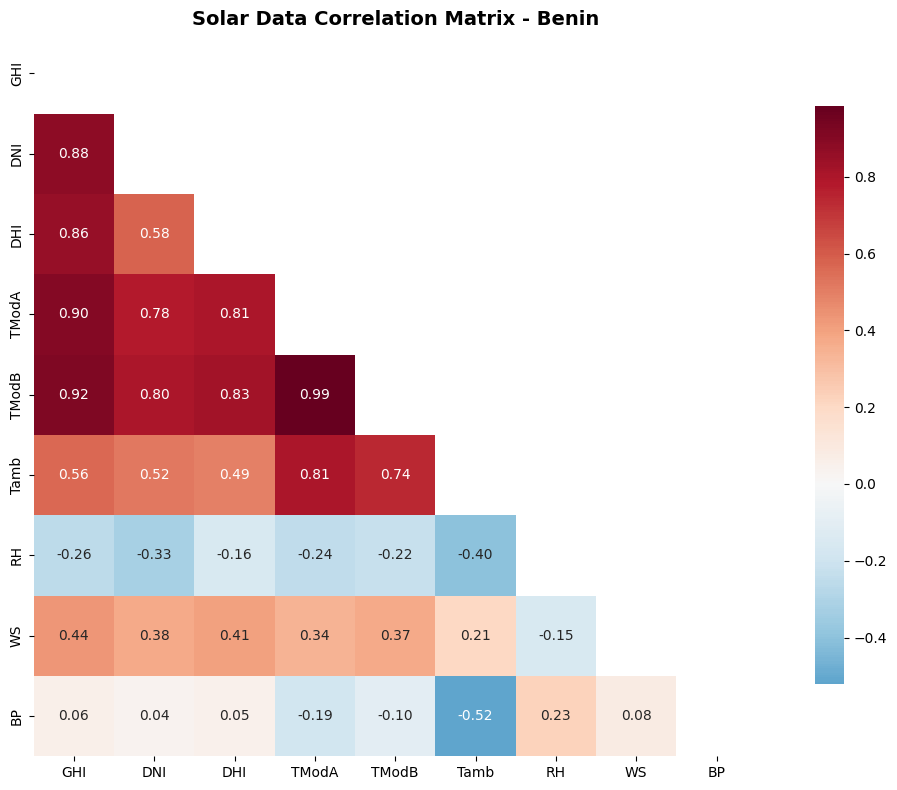


2. STRONG CORRELATIONS (|r| > 0.7):
   - GHI ↔ DNI: 0.884
   - GHI ↔ DHI: 0.855
   - GHI ↔ TModA: 0.899
   - GHI ↔ TModB: 0.920
   - DNI ↔ TModA: 0.782
   - DNI ↔ TModB: 0.800
   - DHI ↔ TModA: 0.807
   - DHI ↔ TModB: 0.825
   - TModA ↔ TModB: 0.985
   - TModA ↔ Tamb: 0.806
   - TModB ↔ Tamb: 0.741

3. SCATTER PLOT RELATIONSHIPS:


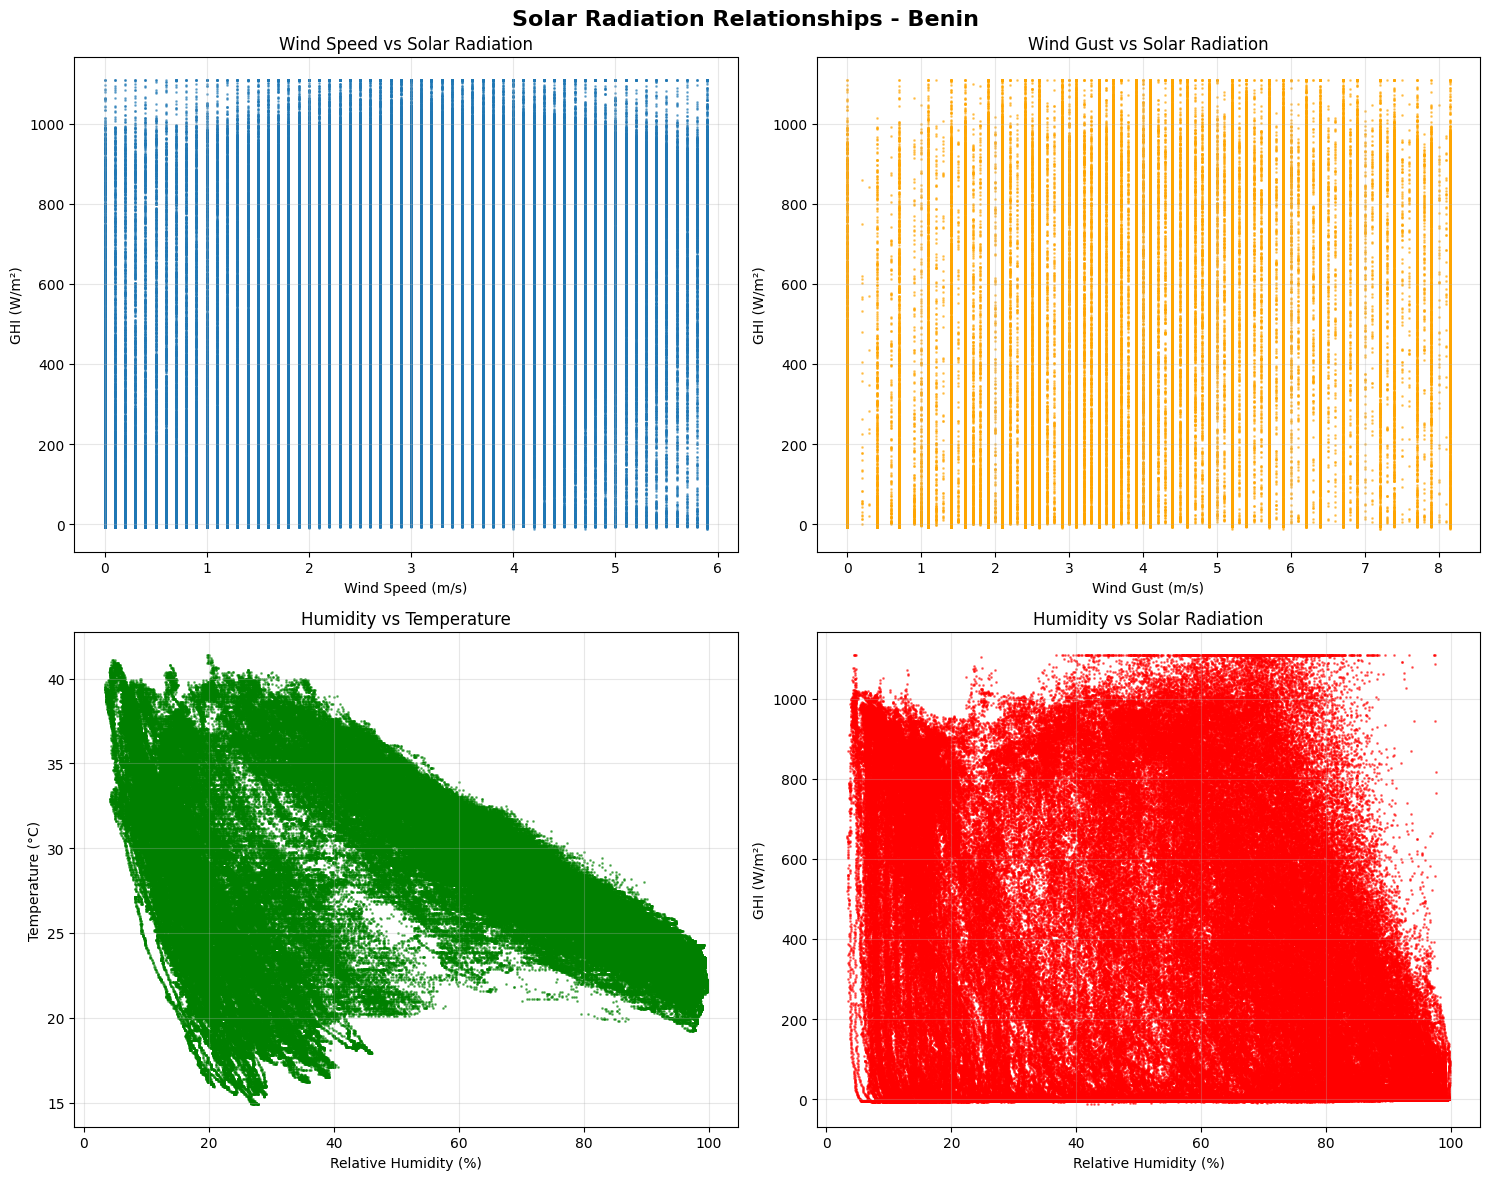


4. KEY INSIGHTS:
   - Wind speed has positive correlation with GHI (r=0.436)
   - Humidity has negative correlation with GHI (r=-0.259)
   - Temperature has positive correlation with GHI (r=0.563)


In [ ]:
# CELL 6: CORRELATION & RELATIONSHIP ANALYSIS
print("📈 CORRELATION & RELATIONSHIP ANALYSIS")
print("=" * 50)

# 1. Correlation Heatmap (REQUIRED)
print("1. CORRELATION HEATMAP:")
correlation_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'BP']
available_corr_columns = [col for col in correlation_columns if col in df_clean.columns]

if len(available_corr_columns) >= 3:  # Need at least 3 columns for meaningful heatmap
    plt.figure(figsize=(12, 8))
    corr_matrix = df_clean[available_corr_columns].corr()
    
    # Create heatmap with annotations
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': .8})
    plt.title('Solar Data Correlation Matrix - Benin', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify strong correlations
    print("\n2. STRONG CORRELATIONS (|r| > 0.7):")
    strong_corrs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                strong_corrs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if strong_corrs:
        for col1, col2, corr in strong_corrs:
            print(f"   - {col1} ↔ {col2}: {corr:.3f}")
    else:
        print("   - No very strong correlations found")
else:
    print("   - Not enough columns for correlation analysis")

# 3. Scatter Plots (REQUIRED)
print("\n3. SCATTER PLOT RELATIONSHIPS:")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Solar Radiation Relationships - Benin', fontsize=16, fontweight='bold')

# Wind Speed vs GHI
if all(col in df_clean.columns for col in ['WS', 'GHI']):
    axes[0,0].scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5, s=1)
    axes[0,0].set_xlabel('Wind Speed (m/s)')
    axes[0,0].set_ylabel('GHI (W/m²)')
    axes[0,0].set_title('Wind Speed vs Solar Radiation')
    axes[0,0].grid(True, alpha=0.3)

# Wind Gust vs GHI
if all(col in df_clean.columns for col in ['WSgust', 'GHI']):
    axes[0,1].scatter(df_clean['WSgust'], df_clean['GHI'], alpha=0.5, s=1, color='orange')
    axes[0,1].set_xlabel('Wind Gust (m/s)')
    axes[0,1].set_ylabel('GHI (W/m²)')
    axes[0,1].set_title('Wind Gust vs Solar Radiation')
    axes[0,1].grid(True, alpha=0.3)

# Relative Humidity vs Temperature
if all(col in df_clean.columns for col in ['RH', 'Tamb']):
    axes[1,0].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5, s=1, color='green')
    axes[1,0].set_xlabel('Relative Humidity (%)')
    axes[1,0].set_ylabel('Temperature (°C)')
    axes[1,0].set_title('Humidity vs Temperature')
    axes[1,0].grid(True, alpha=0.3)

# Relative Humidity vs GHI
if all(col in df_clean.columns for col in ['RH', 'GHI']):
    axes[1,1].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5, s=1, color='red')
    axes[1,1].set_xlabel('Relative Humidity (%)')
    axes[1,1].set_ylabel('GHI (W/m²)')
    axes[1,1].set_title('Humidity vs Solar Radiation')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Key Insights from Relationships
print("\n4. KEY INSIGHTS:")
insights = []

# Wind impact
if 'WS' in df_clean.columns and 'GHI' in df_clean.columns:
    wind_ghi_corr = df_clean['WS'].corr(df_clean['GHI'])
    insights.append(f"Wind speed has { 'positive' if wind_ghi_corr > 0 else 'negative' } correlation with GHI (r={wind_ghi_corr:.3f})")

# Humidity impact
if 'RH' in df_clean.columns and 'GHI' in df_clean.columns:
    rh_ghi_corr = df_clean['RH'].corr(df_clean['GHI'])
    insights.append(f"Humidity has { 'positive' if rh_ghi_corr > 0 else 'negative' } correlation with GHI (r={rh_ghi_corr:.3f})")

# Temperature relationships
if 'Tamb' in df_clean.columns and 'GHI' in df_clean.columns:
    temp_ghi_corr = df_clean['Tamb'].corr(df_clean['GHI'])
    insights.append(f"Temperature has { 'positive' if temp_ghi_corr > 0 else 'negative' } correlation with GHI (r={temp_ghi_corr:.3f})")

for insight in insights:
    print(f"   - {insight}")

🌬️ WIND & DISTRIBUTION ANALYSIS
1. DISTRIBUTION HISTOGRAMS:


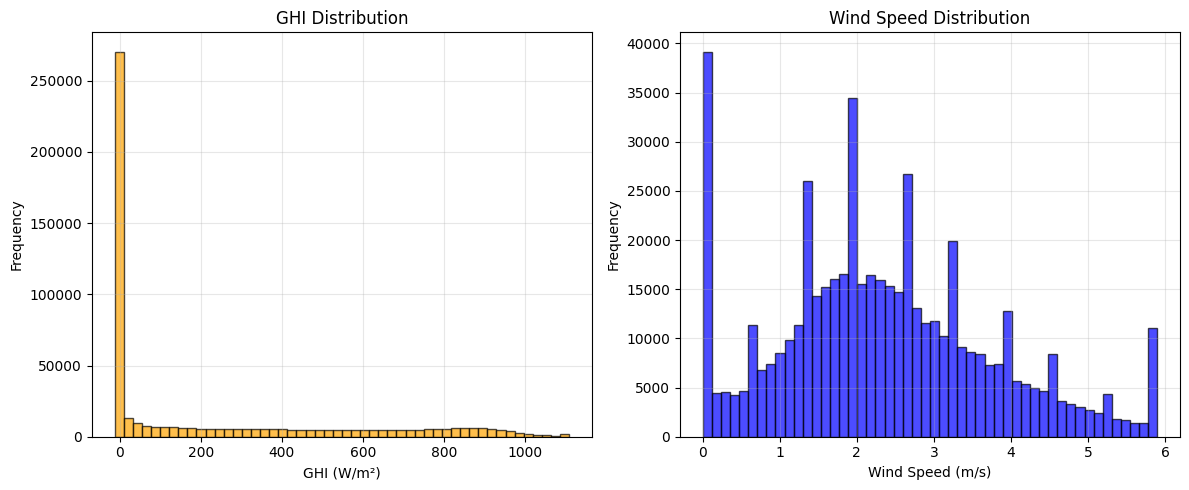

2. WIND DIRECTION ANALYSIS:


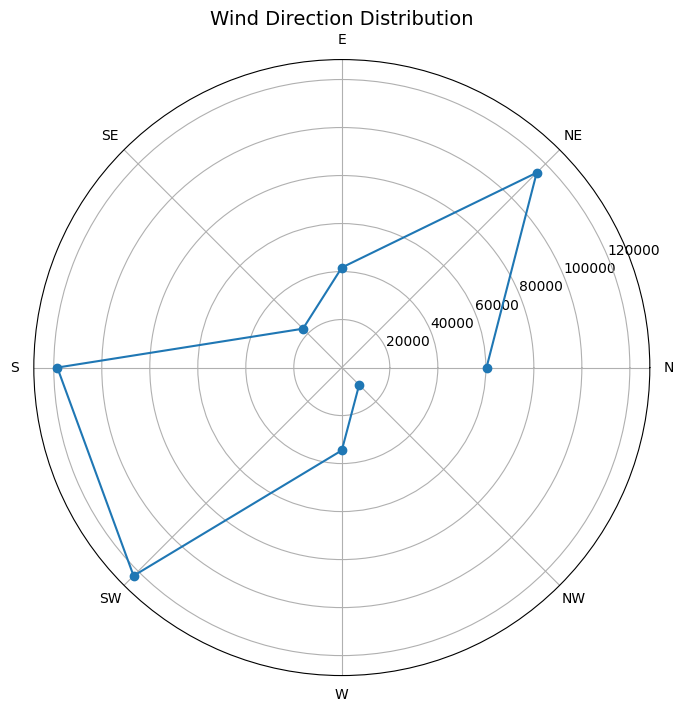

   - Most common wind direction: SW
   - Least common wind direction: NW


In [ ]:
# CELL 7: WIND & DISTRIBUTION ANALYSIS
print("🌬️ WIND & DISTRIBUTION ANALYSIS")
print("=" * 50)

# 1. Histograms for GHI and WS (REQUIRED)
print("1. DISTRIBUTION HISTOGRAMS:")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# GHI Histogram
if 'GHI' in df_clean.columns:
    axes[0].hist(df_clean['GHI'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[0].set_xlabel('GHI (W/m²)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('GHI Distribution')
    axes[0].grid(True, alpha=0.3)

# Wind Speed Histogram  
if 'WS' in df_clean.columns:
    axes[1].hist(df_clean['WS'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[1].set_xlabel('Wind Speed (m/s)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Wind Speed Distribution')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Basic Wind Rose (Simplified - radial bar plot alternative)
print("2. WIND DIRECTION ANALYSIS:")
if 'WD' in df_clean.columns:
    # Group wind directions into sectors
    wind_directions = df_clean['WD'].dropna()
    direction_bins = pd.cut(wind_directions, bins=8, labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    direction_counts = direction_bins.value_counts().sort_index()
    
    # Create radial-like bar plot
    plt.figure(figsize=(8, 8))
    angles = np.linspace(0, 2*np.pi, len(direction_counts), endpoint=False)
    plt.polar(angles, direction_counts.values, marker='o')
    plt.title('Wind Direction Distribution', size=14)
    plt.xticks(angles, direction_counts.index)
    plt.show()
    
    print(f"   - Most common wind direction: {direction_counts.idxmax()}")
    print(f"   - Least common wind direction: {direction_counts.idxmin()}")
else:
    print("   - Wind direction data not available")

In [ ]:
# CELL 8: TEMPERATURE ANALYSIS  
print("🌡️ TEMPERATURE ANALYSIS")
print("=" * 50)

print("1. RELATIVE HUMIDITY INFLUENCE ON TEMPERATURE AND RADIATION:")

# RH vs Temperature relationship
if all(col in df_clean.columns for col in ['RH', 'Tamb']):
    rh_temp_corr = df_clean['RH'].corr(df_clean['Tamb'])
    print(f"   - RH vs Temperature correlation: {rh_temp_corr:.3f}")
    
# RH vs GHI relationship  
if all(col in df_clean.columns for col in ['RH', 'GHI']):
    rh_ghi_corr = df_clean['RH'].corr(df_clean['GHI'])
    print(f"   - RH vs GHI correlation: {rh_ghi_corr:.3f}")

# Temperature ranges and solar efficiency
if 'Tamb' in df_clean.columns:
    temp_stats = df_clean['Tamb'].describe()
    print(f"   - Temperature range: {temp_stats['min']:.1f}°C to {temp_stats['max']:.1f}°C")
    print(f"   - Average temperature: {temp_stats['mean']:.1f}°C")
    
    # Optimal temperature range for solar panels (typically 15-35°C)
    optimal_temp = df_clean[(df_clean['Tamb'] >= 15) & (df_clean['Tamb'] <= 35)]
    optimal_percent = (len(optimal_temp) / len(df_clean)) * 100
    print(f"   - {optimal_percent:.1f}% of time in optimal solar panel temperature range (15-35°C)")

🌡️ TEMPERATURE ANALYSIS
1. RELATIVE HUMIDITY INFLUENCE ON TEMPERATURE AND RADIATION:
   - RH vs Temperature correlation: -0.400
   - RH vs GHI correlation: -0.259
   - Temperature range: 14.9°C to 41.4°C
   - Average temperature: 27.8°C
   - 91.5% of time in optimal solar panel temperature range (15-35°C)


🫧 BUBBLE CHART ANALYSIS


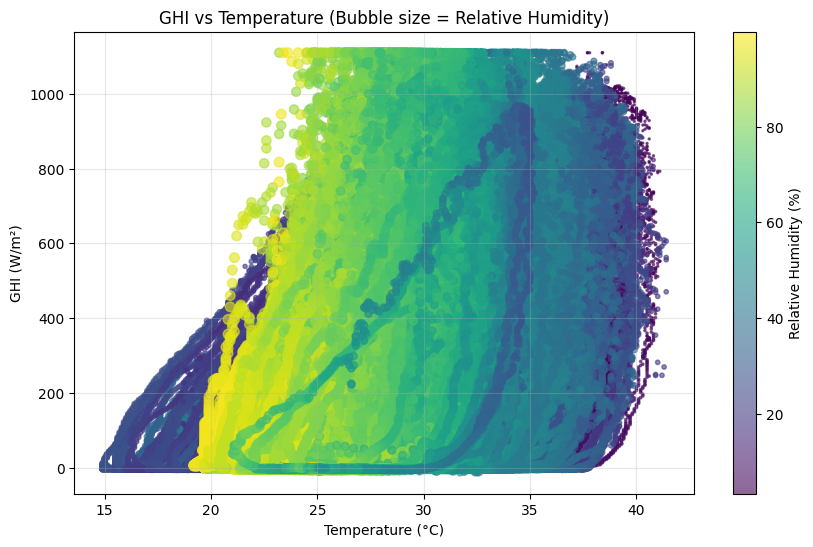

   - Bubble chart shows relationship between GHI, Temperature, and Humidity
   - Larger bubbles indicate higher humidity conditions


In [ ]:
# CELL 9: BUBBLE CHART (REQUIRED)
print("🫧 BUBBLE CHART ANALYSIS")
print("=" * 50)

if all(col in df_clean.columns for col in ['GHI', 'Tamb', 'RH']):
    plt.figure(figsize=(10, 6))
    
    # Create bubble chart: GHI vs Tamb with bubble size = RH
    scatter = plt.scatter(df_clean['Tamb'], df_clean['GHI'], 
                         s=df_clean['RH']/2,  # Scale RH for bubble size
                         alpha=0.6, c=df_clean['RH'], cmap='viridis')
    
    plt.colorbar(scatter, label='Relative Humidity (%)')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('GHI (W/m²)')
    plt.title('GHI vs Temperature (Bubble size = Relative Humidity)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("   - Bubble chart shows relationship between GHI, Temperature, and Humidity")
    print("   - Larger bubbles indicate higher humidity conditions")
else:
    print("   - Required columns (GHI, Tamb, RH) not available for bubble chart")